In [18]:
import os
import cv2
import random

import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline
plt.style.use('seaborn')

from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
import tensorflow as tf
from keras.models import Sequential, load_model
from keras.layers import Conv2D,MaxPooling2D, Dropout,Flatten,Dense,Activation, BatchNormalization
from keras.callbacks import EarlyStopping, ReduceLROnPlateau

### Loading the Data

In [2]:
data_dir = r'PetImages\\'

data = []
labels = []

labels_map = {'Cat': 1, 'Dog': 0}

for sub_dir in os.listdir(data_dir):
    sub_dir_path = os.path.join(data_dir, sub_dir)
    label = labels_map[sub_dir] # Cats or Dogs
    
    for image_filename in os.listdir(sub_dir_path):
        image_path = os.path.join(sub_dir_path, image_filename)
        
        image = cv2.imread(image_path)
        if image is not None:
            image_gray = image / 255.0 # gray scaling
            image_resized = cv2.resize(image_gray, (128, 128)) # resizing
            data.append(image_resized)
            labels.append(label)
    print(f"{sub_dir_path} loading process is done")
        
data = np.array(data)
labels = np.array(labels)

print('Loaing process is done')

PetImages\\Cat loading process is done
PetImages\\Dog loading process is done
Loaing process is done


### Creating DataFrame

In [3]:
df = pd.DataFrame({'images': list(data), 'label': labels})
df_shuffled = df.sample(frac=1).reset_index(drop=True)

In [4]:
df_shuffled.head()

,images,label
0,"[[[0.19548268037683825, 0.19156111174938728, 0...",1
1,"[[[0.7278186274509804, 0.7082107843137255, 0.7...",0
2,"[[[0.48418136297487746, 0.5194754806219363, 0....",0
3,"[[[0.9912324793198529, 0.9868487189797794, 0.9...",0
4,"[[[0.07364424163219976, 0.14784306544883577, 0...",1


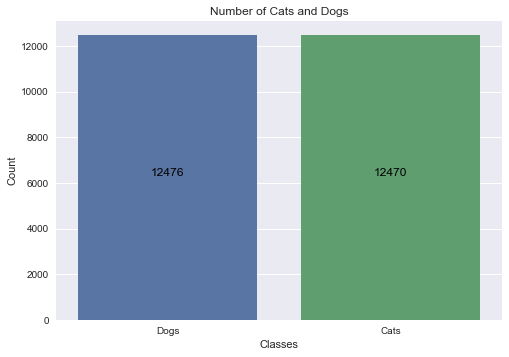

In [5]:
ax = sns.countplot(x=df_shuffled['label'].map({0: 'Cats', 1: 'Dogs'}), data=df_shuffled)

# Annotating the count of each class
for p in ax.patches:
    ax.annotate(f'{p.get_height()}', (p.get_x() + p.get_width() / 2., p.get_height() / 2.),
                ha='center', va='bottom', fontsize=12, color='black')


plt.xlabel('Classes')
plt.ylabel('Count')
plt.title('Number of Cats and Dogs')

plt.show()

### NOTE-> Did not perfrom Data Augmentation due to decrease in accuracy

### Train Test Split

In [9]:
X, y= df_shuffled['images'], df_shuffled['label']

train_size, val_size, test_size = 0.75, 0.15, 0.1

x_train, x_test, y_train, y_test = train_test_split(X, y, test_size=1 - train_size, random_state=42)

x_val, x_test, y_val, y_test = train_test_split(x_test, y_test, test_size=test_size/(test_size + val_size))

In [10]:
# Maikng sure that the data is splitted correctly
print(x_train.shape[0] / len(X), x_test.shape[0] / len(X), x_val.shape[0] / len(X))

0.749979956706486 0.1000160346348112 0.1500040086587028


### Training 

In [11]:
model = Sequential()

model.add(Conv2D(32,(3,3),activation='relu',input_shape=(128, 128, 3)))
model.add(BatchNormalization())
model.add(MaxPooling2D(pool_size=(2,2)))
model.add(Dropout(0.25))

model.add(Conv2D(64,(3,3),activation='relu'))
model.add(BatchNormalization())
model.add(MaxPooling2D(pool_size=(2,2)))
model.add(Dropout(0.25))

model.add(Conv2D(128,(3,3),activation='relu'))
model.add(BatchNormalization())
model.add(MaxPooling2D(pool_size=(2,2)))
model.add(Dropout(0.25))
model.add(Flatten())

model.add(Dense(512,activation='relu'))
model.add(BatchNormalization())#
model.add(Dropout(0.5))

model.add(Dense(1,activation='sigmoid'))

model.compile(loss='binary_crossentropy',
  optimizer='adam',metrics=['accuracy'])

In [12]:
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 126, 126, 32)      896       
                                                                 
 batch_normalization (BatchN  (None, 126, 126, 32)     128       
 ormalization)                                                   
                                                                 
 max_pooling2d (MaxPooling2D  (None, 63, 63, 32)       0         
 )                                                               
                                                                 
 dropout (Dropout)           (None, 63, 63, 32)        0         
                                                                 
 conv2d_1 (Conv2D)           (None, 61, 61, 64)        18496     
                                                                 
 batch_normalization_1 (Batc  (None, 61, 61, 64)       2

##### Defining Early Stops and Learning Rate Reduction Actions

In [13]:
# Defining early stop action, if val loss does not improve for 3 epochs
earlystop = EarlyStopping(patience = 3) 
# Defining learning rate reduction action, if the val accuracy stops improving for 2 epochs
learning_rate_reduction = ReduceLROnPlateau(monitor = 'val_accuracy',patience = 2,verbose = 1,factor = 0.5,min_lr = 0.00001)
callbacks = [earlystop,learning_rate_reduction]

##### Training

In [14]:
model.fit(x=np.stack(x_train), y=y_train, epochs=10, validation_data=(np.stack(x_val), y_val), callbacks=callbacks)

Epoch 1/10
585/585 [==============================] - 336s 569ms/step - loss: 0.6781 - accuracy: 0.6633 - val_loss: 0.6988 - val_accuracy: 0.6678 - lr: 0.0010
Epoch 2/10
585/585 [==============================] - 340s 581ms/step - loss: 0.5073 - accuracy: 0.7509 - val_loss: 0.4782 - val_accuracy: 0.7702 - lr: 0.0010
Epoch 3/10
585/585 [==============================] - 334s 572ms/step - loss: 0.4327 - accuracy: 0.7969 - val_loss: 0.5389 - val_accuracy: 0.7357 - lr: 0.0010
Epoch 4/10
585/585 [==============================] - ETA: 0s - loss: 0.3892 - accuracy: 0.8242
Epoch 4: ReduceLROnPlateau reducing learning rate to 0.0005000000237487257.
585/585 [==============================] - 332s 567ms/step - loss: 0.3892 - accuracy: 0.8242 - val_loss: 0.5420 - val_accuracy: 0.7389 - lr: 0.0010
Epoch 5/10
585/585 [==============================] - 327s 558ms/step - loss: 0.3120 - accuracy: 0.8658 - val_loss: 0.4805 - val_accuracy: 0.7905 - lr: 5.0000e-04
Epoch 6/10
585/585 [====================

### Saving

In [32]:
model.save("cats-dogs_classification.h5")

### Testing

In [ ]:
loaded_model = load_model("cats-dogs_classification.h5")

In [36]:
predictions = loaded_model.predict(x=np.stack(x_test))
predicted_labels = (predictions > 0.5).astype(int)

78/78 [==============================] - 14s 185ms/step


### Evaluating

In [28]:
loss, accuracy= loaded_model.evaluate(x=np.stack(x_test), y=y_test)

print(f"Loss is: {loss} \nAccuracy is: {accuracy}")

78/78 [==============================] - 15s 187ms/step - loss: 0.4133 - accuracy: 0.8485
Loss is: 0.4133108854293823 
Accuracy is: 0.8484969735145569


In [29]:
print(classification_report(y_true=y_test, y_pred=predicted_labels))

              precision    recall  f1-score   support

           0       0.91      0.77      0.83      1239
           1       0.80      0.93      0.86      1256

    accuracy                           0.85      2495
   macro avg       0.86      0.85      0.85      2495
weighted avg       0.86      0.85      0.85      2495



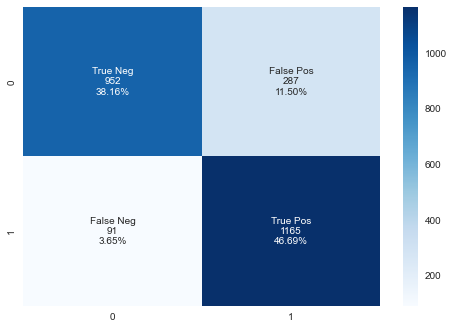

In [30]:
log_matrix= confusion_matrix(y_true=y_test,y_pred=predicted_labels)
group_names = ['True Neg','False Pos','False Neg','True Pos']
group_counts = ["{0:0.0f}".format(value) for value in log_matrix.flatten()]
group_percent = ["{0:.2%}".format(value) for value in log_matrix.flatten()/np.sum(log_matrix)]

labels = [[f"{v1}\n{v2}\n{v3}" for v1, v2, v3 in
          zip(group_names,group_counts,group_percent)]]
labels = np.asarray(labels).reshape(2,2)

sns.heatmap(log_matrix,annot=labels, fmt='', cmap='Blues')

plt.show()